# 1 Imports

In [1]:
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from ev_load_fc.config import CFG, resolve_path
from ev_load_fc.training.optuna_api import objective

feature_store = resolve_path(CFG["paths"]["feature_store"])
feature_version = CFG["training"]["feature_version"]
target = CFG["features"]["target"]

c:\Users\Cameron\projects\ev_load_fc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv(feature_store / f"train_{feature_version}.csv", parse_dates=["timestamp"], index_col="timestamp")
test  = pd.read_csv(feature_store / f"test_{feature_version}.csv", parse_dates=["timestamp"], index_col="timestamp")

features = train.columns.drop(target)
X_train  = train[features]
X_test   = test[features]
y_train  = np.ravel(train[target])
y_test   = np.ravel(test[target])

# 2 Random Forest

## Optuna training

In [3]:
RF_search_space = {
    'n_estimators' : [50,150], 
    'max_depth' : [2,8], 
    'min_samples_split' : [5,10],
    'min_samples_leaf' : [5,10],
    'max_leaf_nodes' : [5,20], 
    'max_features' : ['sqrt'],
    'max_samples' : [None]
}

In [4]:
rf_study = optuna.create_study(study_name='random_forest_study', direction='maximize')
rf_study.optimize(
    lambda trial: objective(trial=trial, model="Random Forest", X=X_train, y=y_train, search_space=RF_search_space, n_splits=3), 
    n_trials=50, 
    # show_progress_bar=True, 
    n_jobs=-1
)

[I 2025-12-30 13:38:36,263] A new study created in memory with name: random_forest_study
[I 2025-12-30 13:38:40,192] Trial 0 finished with value: -30.29244752236367 and parameters: {'n_estimators': 58, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_leaf_nodes': 13, 'max_features': 'sqrt', 'max_samples': None}. Best is trial 0 with value: -30.29244752236367.
[I 2025-12-30 13:38:42,056] Trial 4 finished with value: -29.044635738598448 and parameters: {'n_estimators': 73, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_leaf_nodes': 15, 'max_features': 'sqrt', 'max_samples': None}. Best is trial 4 with value: -29.044635738598448.
[I 2025-12-30 13:38:43,174] Trial 1 finished with value: -32.38551178092504 and parameters: {'n_estimators': 138, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_leaf_nodes': 17, 'max_features': 'sqrt', 'max_samples': None}. Best is trial 4 with value: -29.044635738598448.
[I 2025-12-30 13:38:43,325] T

In [ ]:
rf_params = rf_study.best_params
print(rf_params)
# {'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_leaf_nodes': 18, 'max_features': 'sqrt', 'max_samples': None}

{'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_leaf_nodes': 18, 'max_features': 'sqrt', 'max_samples': None}


## Plot predictions

In [ ]:
rf_best = RandomForestRegressor(**rf_params)
rf_best.fit(X_train, y_train)

,n_estimators,55
,criterion,'squared_error'
,max_depth,8
,min_samples_split,6
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,18
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
rf_preds = rf_best.predict(X_test)

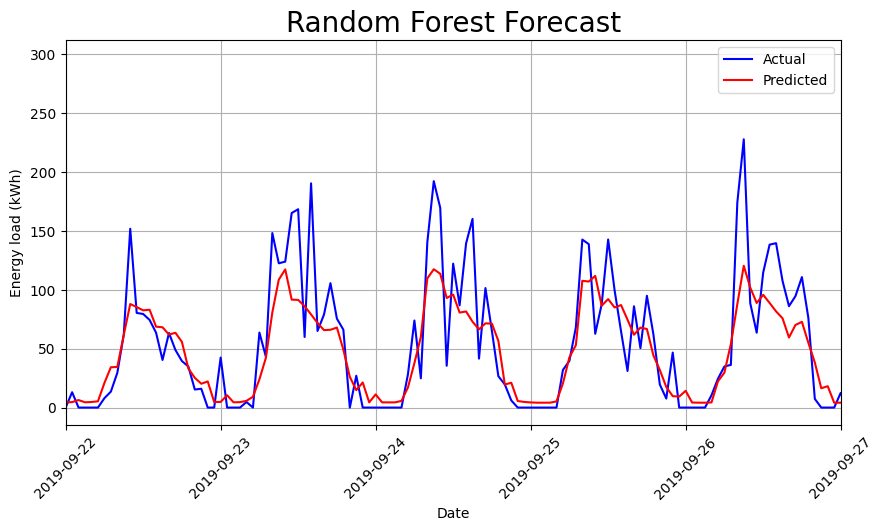

In [ ]:
eval_min = datetime(2019,9,22)
eval_max = datetime(2019,9,27)

fig = plt.figure(figsize=(10,5))
plt.title('Random Forest Forecast', fontsize=20)
plt.plot(X_test.index, y_test, label='Actual', color='blue')
plt.plot(X_test.index, rf_preds, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Energy load (kWh)')
plt.xticks(rotation=45)
plt.xlim(eval_min, eval_max) 
plt.grid()
plt.show()

In [ ]:
# Average load for test set
naive_test_mean = np.mean(y_test)
print(f'Mean test energy load (kWh): {naive_test_mean:.2f}')
# Random Forest MAE for test set
rf_test_mae = mean_absolute_error(y_test, rf_preds)
print(f'Random Forest test MAE (kWh): {rf_test_mae:.2f}')
# Random Forest RMSE for test set
rf_rmse = root_mean_squared_error(y_test, rf_preds)
print(f'Random Forest test RMSE (kWh): {rf_rmse:.2f}')

Mean test energy load (kWh): 53.56
Random Forest test MAE (kWh): 22.48
Random Forest test RMSE (kWh): 32.31


## Feature Importance

In [ ]:
rf_best = RandomForestRegressor(**rf_params)
rf_best.fit(X_train, y_train)

,n_estimators,51
,criterion,'squared_error'
,max_depth,8
,min_samples_split,6
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,20
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
pi = permutation_importance(
        estimator=rf_best,
        X=X_test,
        y=y_test,
        n_repeats=5,
        scoring="neg_root_mean_squared_error",
        random_state=42,
        n_jobs=-1,
    )

In [8]:
mean_importances = pi.importances_mean
pi_series = pd.Series(data=mean_importances, index=X_test.columns)

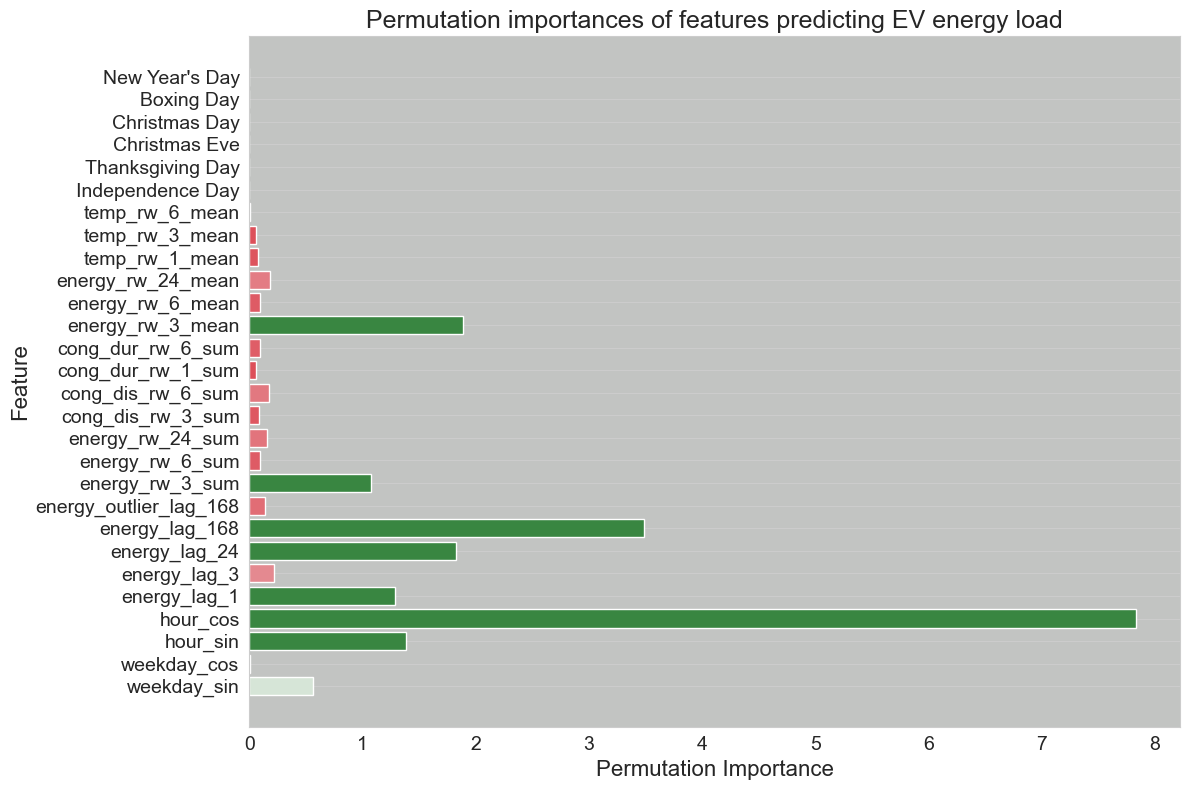

In [9]:
# Generate a color palette from red to green
colors = sns.diverging_palette(10, 130, as_cmap=True)
color_mapped = pi_series.map(colors)

# Set Seaborn style
sns.set_style(
    "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
)  # Light grey background and thicker grid lines

# Create bar plot
fig = plt.figure(figsize=(12, 8))
plt.barh(pi_series.index, pi_series.values, color=color_mapped)

# Set labels and title with increased font size
plt.title(f"Permutation importances of features predicting EV energy load", fontsize=18)
plt.xlabel("Permutation Importance", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="x")

plt.tight_layout()

## Residuals

In [ ]:
    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()
